# Notebook de prueba

Este notebook es un ejemplo cómo procesar y utilizar los datos de entrenamiento y de prueba para la competición https://www.kaggle.com/competitions/playground-series-s4e9/ de la práctica 3 de Inteligencia de Negocio.

Es un ejemplo que es claramente mejorable, se deja a el/la estudiante el mejorarlo para obtener mejores resultados.

## Carga de librería

Lo primero es cargar las librerías.

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

## Lectura de datos

Ahora leemos los datos.

In [73]:
train = pd.read_csv("./train.csv", na_values="NaN", sep = ",") # Definimos na_values para identificar bien los valores perdidos
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [74]:
train.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [75]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [76]:
train.shape

(188533, 13)

## Visualización

Vamos a hacer unas ligeras visualizaciones de ejemplo.

Ahora visualizo los precios de venta en el conjunto de entrenamiento.

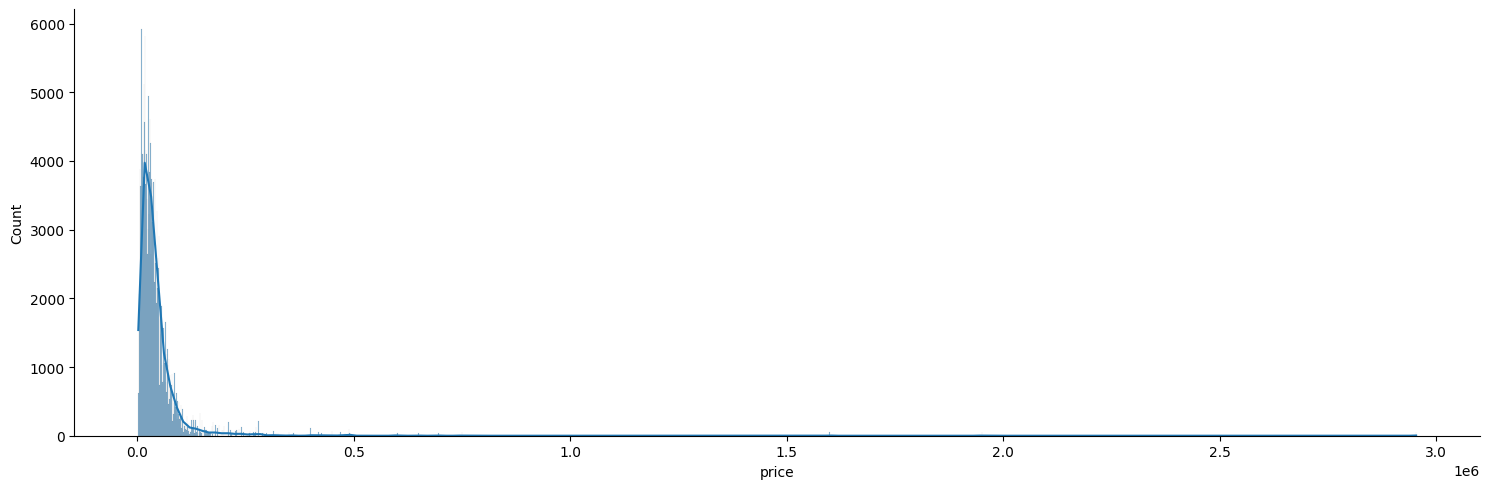

In [77]:
sns.displot(data=train, x="price", aspect=3, kde=True)

Ahora visualizamos cómo cambia la distribución (usando un boxplot) según otro atributo, en este caso nos quedamos con un subconjunto de marcas

In [78]:
marcas = train[train['brand'].str.contains('MINI|BMW|Nissan', regex = True) ]


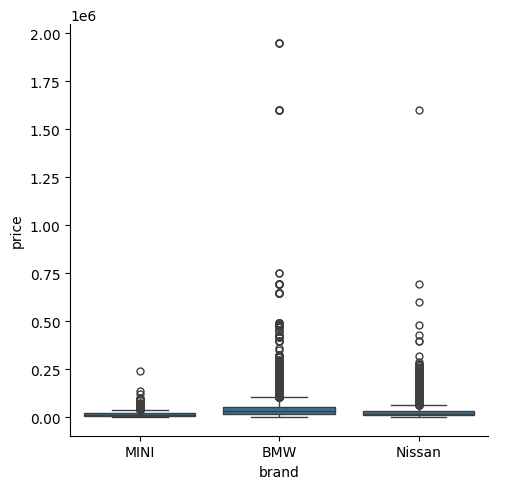

In [79]:

sns.catplot(data=marcas, y="price", x='brand', kind="box")


## Procesar datos

Vamos a procesar datos:
- Valores perdidos.
- Etiquetado.

Primero quito el Id de train que no me sirve de nada, y complica el etiquetado. También la quito de test pero antes lo guardo (para el fichero de salida)

In [80]:
if 'id' in train:
    train.drop('id', axis=1, inplace=True)

In [81]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

In [82]:
test = pd.read_csv("test.csv", na_values="NaN")
test_ids = test.id
test = test.drop('id', axis=1)

Concateno la entrada de ambos para los procesos de etiquetado, que aprenda con ambos conjuntos

In [83]:
input_all = pd.concat([train.drop('price', axis=1), test])

In [84]:
input_all.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title'],
      dtype='object')

Ahora selecciono los atributos de tipo categórico (los que no son numéricos)

In [85]:
col_cat = list(input_all.select_dtypes(exclude=np.number).columns)

In [86]:
col_cat

['brand',
 'model',
 'fuel_type',
 'engine',
 'transmission',
 'ext_col',
 'int_col',
 'accident',
 'clean_title']

Compruebo que son realmente categóricos.

In [87]:
input_all[col_cat].head()

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,MINI,Cooper S Base,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes
1,Lincoln,LS V8,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes
2,Chevrolet,Silverado 2500 LT,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes
3,Genesis,G90 5.0 Ultimate,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes
4,Mercedes-Benz,Metris Base,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes


## Extraer características del motor de coche

In [88]:
# Añadido por Carmen
# extraer características relacionadas con el motor del coche a partir
# de la columna engine -> para ello usa expresionaes regulares
import re
def extract_engine_feature(df):
    # extract horsepower
    df['Horsepower'] = df['engine'].apply(lambda x: float(re.search(r'(\d+(\.\d+)?)HP', x).group(1)) if re.search(r'(\d+(\.\d+)?)HP', x) else None)

    # extract displacement
    df['Displacement'] = df['engine'].apply(lambda x: float(re.search(r'(\d+\.\d+)L|(\d+\.\d+) Liter', x).group(1) or re.search(r'(\d+\.\d+)L|(\d+\.\d+) Liter', x).group(2)) if re.search(r'(\d+\.\d+)L|(\d+\.\d+) Liter', x) else None)

    # extract engine type
    df['Engine Type'] = df['engine'].apply(lambda x: re.search(r'(V\d+|I\d+|Flat \d+|Straight \d+)', x).group(1) if re.search(r'(V\d+|I\d+|Flat \d+|Straight \d+)', x) else None)

    # extract cylinder count
    df['Cylinder Count'] = df['engine'].apply(lambda x: int(re.search(r'(\d+) Cylinder', x).group(1)) if re.search(r'(\d+) Cylinder', x) else None)

    # extract fuel type
    fuel_types = ['Gasoline', 'Diesel', 'Electric', 'Hybrid', 'Flex Fuel']
    df['Fuel Type'] = df['engine'].apply(lambda x: next((fuel for fuel in fuel_types if fuel in x), None))

    return df

In [89]:
# añadido por Carmen
# applying the function to both train and test datasets
train = extract_engine_feature(train)
test = extract_engine_feature(test)

In [90]:
# mostrar las columnas de train
train.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'Horsepower', 'Displacement', 'Engine Type', 'Cylinder Count',
       'Fuel Type'],
      dtype='object')

In [91]:
# eliminar columna Fuel Type
train = train.drop('Fuel Type', axis=1)
test = test.drop('Fuel Type', axis=1)

In [92]:
# eliminar columna engine
train = train.drop('engine', axis=1)
test = test.drop('engine', axis=1)

In [93]:
input_all = extract_engine_feature(input_all)
input_all = input_all.drop('Fuel Type', axis=1)
input_all = input_all.drop('engine', axis=1)

In [94]:
input_all.head()

,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,Horsepower,Displacement,Engine Type,Cylinder Count
0,MINI,Cooper S Base,2007,213000,Gasoline,A/T,Yellow,Gray,None reported,Yes,172.0,1.6,None,4.0
1,Lincoln,LS V8,2002,143250,Gasoline,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,252.0,3.9,None,8.0
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,A/T,Blue,Gray,None reported,Yes,320.0,5.3,None,8.0
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,420.0,5.0,None,8.0
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,7-Speed A/T,Black,Beige,None reported,Yes,208.0,2.0,None,4.0


## Proceso valores perdidos

In [95]:
test.isnull().sum()

,0
brand,0
model,0
model_year,0
milage,0
fuel_type,3383
transmission,0
ext_col,0
int_col,0
accident,1632
clean_title,14239


In [96]:
train.isnull().sum()

,0
brand,0
model,0
model_year,0
milage,0
fuel_type,5083
transmission,0
ext_col,0
int_col,0
accident,2452
clean_title,21419


# preprocesamiento profesor

Hay valores perdidos tanto en el conjunto de entrenamiento como en el de test.

In [97]:
from sklearn.impute import SimpleImputer

Voy a reemplazar los valores categóricos por el más frecuente (es mejorable)

In [98]:
col_cat = list(input_all.select_dtypes(exclude=np.number).columns)
col_cat

['brand',
 'model',
 'fuel_type',
 'transmission',
 'ext_col',
 'int_col',
 'accident',
 'clean_title',
 'Engine Type']

In [99]:
imputer_cat = SimpleImputer(strategy="most_frequent")
imputer_cat.fit(input_all[col_cat])
train[col_cat] = imputer_cat.transform(train[col_cat])
test[col_cat] = imputer_cat.transform(test[col_cat])

Compruebo que la variable objetivo no tenga valores nulos. Si fuese el caso habría que borrar dichas instancias.

In [100]:
train.price.isnull().sum()

0

Ahora reemplazo los valores numéricos por la mediana.

In [101]:
col_num = list(train.select_dtypes(include=np.number).columns)
col_num.remove('price')
imputer_num = SimpleImputer(strategy="median") #aquí se debe modificar por mean para el preprocesameinto general
imputer_num.fit(input_all[col_num])
train[col_num] = imputer_num.transform(train[col_num])
test[col_num] = imputer_num.transform(test[col_num])

## Manejo variables booleanas

In [102]:
def mapping_columns(df):
    # replace values in the 'accident' column
    df['accident'] = df['accident'].replace({
        'At least 1 accident or damage reported': 1,
        'None reported': 0
    })

    # replace values in the 'clean_title' column
    df['clean_title'] = df['clean_title'].replace({
        'Yes': 1,
        'No': 0
    })

    return df

In [103]:
train = mapping_columns(train)
test = mapping_columns(test)
input_all = mapping_columns(input_all)

<ipython-input-102-2028b69d9bc1>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['accident'] = df['accident'].replace({
<ipython-input-102-2028b69d9bc1>:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['clean_title'] = df['clean_title'].replace({


In [104]:
input_all.head()

,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,Horsepower,Displacement,Engine Type,Cylinder Count
0,MINI,Cooper S Base,2007,213000,Gasoline,A/T,Yellow,Gray,0.0,1.0,172.0,1.6,None,4.0
1,Lincoln,LS V8,2002,143250,Gasoline,A/T,Silver,Beige,1.0,1.0,252.0,3.9,None,8.0
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,A/T,Blue,Gray,0.0,1.0,320.0,5.3,None,8.0
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,Transmission w/Dual Shift Mode,Black,Black,0.0,1.0,420.0,5.0,None,8.0
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,7-Speed A/T,Black,Beige,0.0,1.0,208.0,2.0,None,4.0


## Hago el etiquetado

Ahora hago el etiquetado con LabelEncoder, usando un diccionario de LabelEncoder

In [105]:
from sklearn.preprocessing import LabelEncoder
labelers = {}
test_l = test.copy()
train_l = train.copy()

for col in col_cat:
    labelers[col] = LabelEncoder().fit(input_all[col])
    test_l[col] = labelers[col].transform(test[col])
    train_l[col] = labelers[col].transform(train[col])


In [106]:
train_l.head()

,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,Horsepower,Displacement,Engine Type,Cylinder Count
0,31,495,2007.0,213000.0,2,38,312,71,0,0,4200,172.0,1.6,9,4.0
1,28,930,2002.0,143250.0,2,38,263,10,1,0,4999,252.0,3.9,9,8.0
2,9,1575,2002.0,136731.0,1,38,38,71,0,0,13900,320.0,5.3,9,8.0
3,16,758,2017.0,19500.0,2,49,29,14,0,0,45000,420.0,5.0,9,8.0
4,36,1077,2021.0,7388.0,2,23,29,10,0,0,97500,208.0,2.0,9,4.0


Compruebo que estén todos los atributos

In [107]:
assert((train_l.columns == train.columns).all())

## Ahora preparo los conjuntos de entrenamiento y test

Defino en X_train los valores sin el atributo a predecir, y.

También voy a eliminar el Id de entrenamiento que es problemático, pero lo guardo para el fichero de salida.


In [108]:
y_train = train_l.price
X_train = train_l.drop('price', axis=1)

if 'id' in test_l:
    test_l.drop('id', axis=1, inplace=True)

X_test = test_l

## Aplico modelo

Voy a aplicar un modelo muy sencillo, un árbol de decisión.

In [109]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()

In [110]:
from sklearn.model_selection import cross_val_score


Uso la métrica que aplica la competición. Los modelos tienden a maximizar, por eso la métrica de error tiene signo negativo.

In [111]:
import sklearn
# Estas son las métricas posibles
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'd2_absolute_error_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_max_error',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'neg_root_mean_squared_log_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 're

In [112]:
values = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print(values)
print(values.mean())

[-109841.00659664 -113421.28357447 -114237.38236616 -106757.98215673
 -124697.85761535]
-113791.10246186944


Ahora vamos a entrenar con todo el conjunto de entrenamiento

In [113]:
model.fit(X_train, y_train)

DecisionTreeRegressor()

Ahora predigo.

In [114]:
pred = model.predict(X_test)

Guardo el fichero de salida para evaluar:

In [115]:
salida = pd.DataFrame({'id': test_ids, 'price': pred})

In [116]:
salida.to_csv("Prueba2.csv", index=False)

Ahora se puede subir el nuevo fichero a la competición.

## Visualizacion

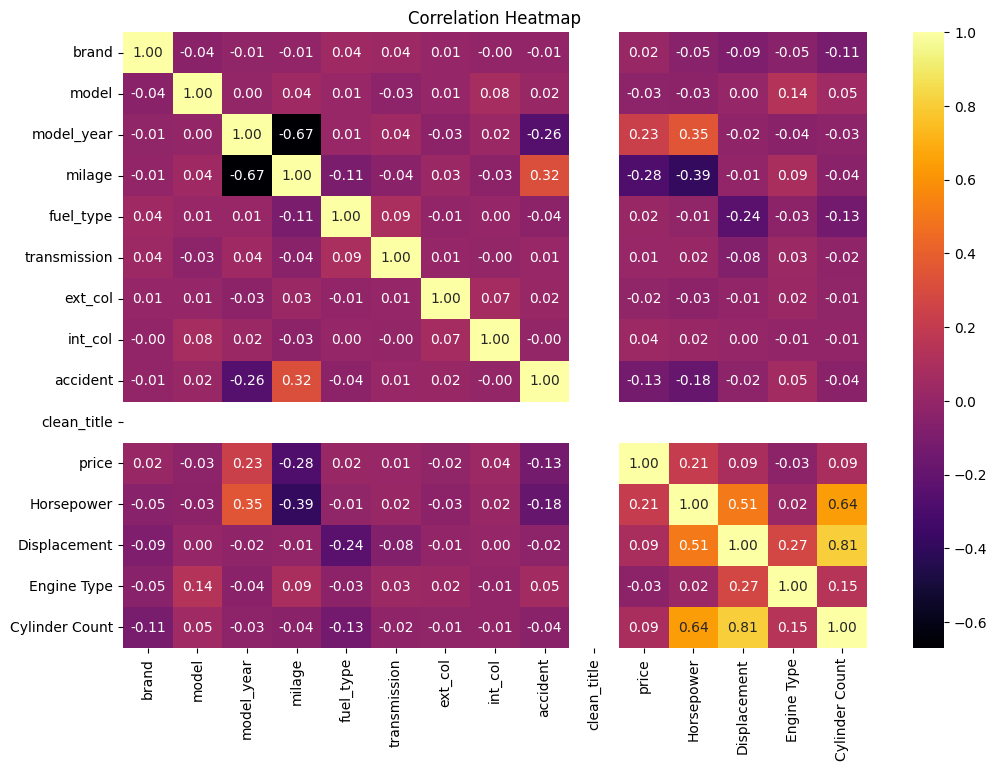

In [117]:
plt.figure(figsize=(12, 8))
sns.heatmap(train_l.corr(), annot=True, cmap='inferno', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [118]:
# eliminar la columna clean_title
train_l = train_l.drop('clean_title', axis=1)
test_l = test_l.drop('clean_title', axis=1)
input_all = input_all.drop('clean_title', axis=1)

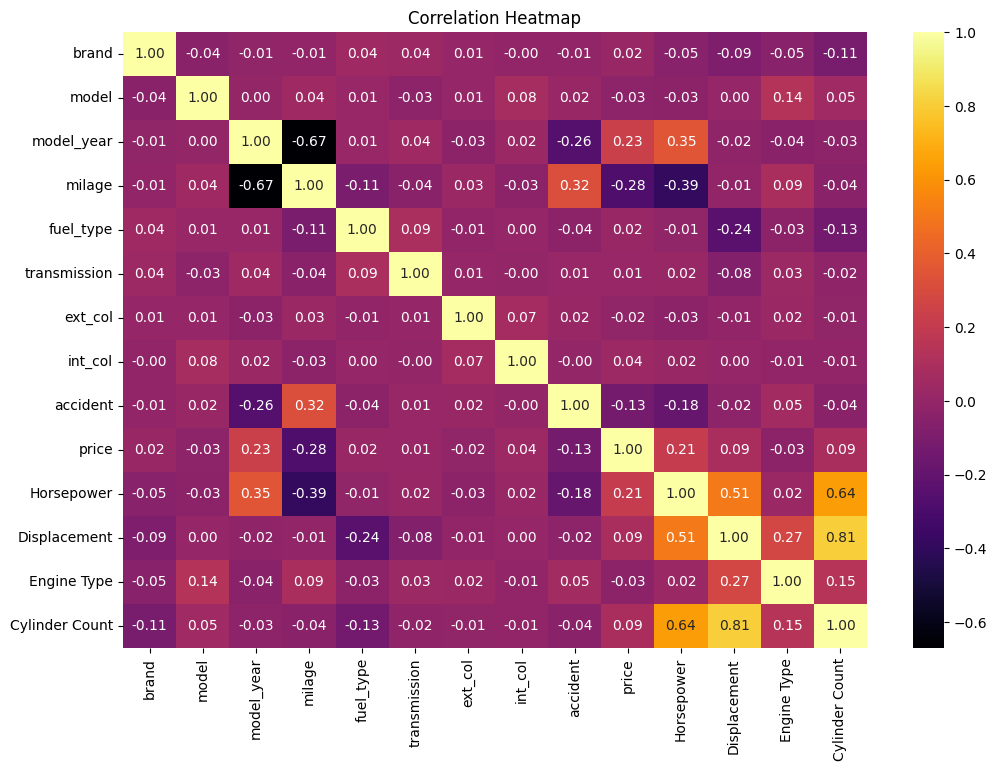

In [119]:
plt.figure(figsize=(12, 8))
sns.heatmap(train_l.corr(), annot=True, cmap='inferno', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## Aplico Random Forest

In [120]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

In [121]:
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [122]:
# Modelo inicial
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train_split, y_train_split)

# Evaluar en el conjunto de validación
y_val_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"RMSE en validación: {rmse}")

RMSE en validación: 75014.23866401253


In [123]:
# Genero predicciones para el test set
y_test_pred = model.predict(X_test)

In [124]:
salida = pd.DataFrame({'id': test_ids, 'price': y_test_pred})

In [125]:
salida.to_csv("RFMean.csv", index=False)

## Ajusto hiperparámetros usando GridSearchCV

In [126]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Definir el modelo
model = RandomForestRegressor(random_state=42)

# Definir los parámetros que se van a ajustar
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles
    'max_depth': [10, 20, None],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Número mínimo de muestras en cada hoja
    'max_features': ['auto', 'sqrt']  # Número de características a considerar para dividir
}

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Entrenar el modelo con GridSearchCV
grid_search.fit(X_train_split, y_train_split)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados: ", grid_search.best_params_)

# Evaluar el modelo con los mejores parámetros
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"RMSE con GridSearchCV: {rmse}")


Fitting 3 folds for each of 162 candidates, totalling 486 fits


KeyboardInterrupt: 

In [ ]:
# Genero predicciones para el test set
y_test_pred = best_model.predict(X_test)

In [ ]:
salida = pd.DataFrame({'id': test_ids, 'price': y_test_pred})

In [ ]:
salida.to_csv("RandomForestGridSearch.csv", index=False)

## Aplico Gradient Boosting Machines

In [127]:
from sklearn.ensemble import GradientBoostingRegressor

In [128]:
# Definir el modelo
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo
gb_model.fit(X_train_split, y_train_split)

# Evaluar en validación
y_val_pred_gb = gb_model.predict(X_val)
rmse_gb = np.sqrt(mean_squared_error(y_val, y_val_pred_gb))
print(f"RMSE con Gradient Boosting: {rmse_gb}")

RMSE con Gradient Boosting: 68366.27574729809


In [129]:
y_test_pred = gb_model.predict(X_test)

In [130]:
salida = pd.DataFrame({'id': test_ids, 'price': y_test_pred})

In [131]:
salida.to_csv("GBMean.csv", index=False)

## Aplicar KNN

In [132]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val)

In [133]:
# incluir KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor

In [62]:
for k in range(1, 10):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train_split)
    y_val_pred = knn.predict(X_val_scaled)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    print(f"n_neighbors: {k}, RMSE: {rmse}")

n_neighbors: 1, RMSE: 101596.59781526652
n_neighbors: 2, RMSE: 87882.77943886537
n_neighbors: 3, RMSE: 81252.86263351598
n_neighbors: 4, RMSE: 77571.39668624448
n_neighbors: 5, RMSE: 75594.32628977267
n_neighbors: 6, RMSE: 74329.77687908045
n_neighbors: 7, RMSE: 73288.5676006131
n_neighbors: 8, RMSE: 72693.78431843237
n_neighbors: 9, RMSE: 72203.58466235109


In [63]:
for k in range(10, 20):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train_split)
    y_val_pred = knn.predict(X_val_scaled)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    print(f"n_neighbors: {k}, RMSE: {rmse}")

n_neighbors: 10, RMSE: 71896.54192684645
n_neighbors: 11, RMSE: 71594.37166683514
n_neighbors: 12, RMSE: 71257.04399563101
n_neighbors: 13, RMSE: 71026.24253904916
n_neighbors: 14, RMSE: 70883.69068413024
n_neighbors: 15, RMSE: 70716.43553191172
n_neighbors: 16, RMSE: 70572.17661567082
n_neighbors: 17, RMSE: 70374.98972965965
n_neighbors: 18, RMSE: 70338.17249465398
n_neighbors: 19, RMSE: 70223.91421008369


In [134]:
from sklearn.neighbors import KNeighborsRegressor

# Configura el modelo KNN
knn = KNeighborsRegressor(n_neighbors=19)  # Puedes ajustar 'n_neighbors' para optimización
knn.fit(X_train_scaled, y_train_split)

# Realiza predicciones
y_val_pred = knn.predict(X_val_scaled)

In [135]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"RMSE: {rmse}")

RMSE: 70259.06997226684


In [ ]:
y_test_pred = gb_model.predict(X_test)
salida = pd.DataFrame({'id': test_ids, 'price': y_test_pred})
salida.to_csv("KNNMean.csv", index=False)